In [156]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchmetrics.functional.classification import binary_accuracy
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# read data from dementia_patients_health_data 2.csv file into a pandas dataframe
patients_health_df = pd.read_csv(f'{os.getcwd()}/dementia_patients_health_data 2.csv')

X = patients_health_df.drop(columns = ["Dementia", "Dosage in mg", "Education_Level" ])
y= patients_health_df['Dementia']
X['Prescription'] = np.where(X['Prescription'].isna(), 0, 1)

# split training data into 80% training and 20% validation
X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=0.2, random_state=123)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

# Preprocess data - transform categorical columns to numeric columns using OneHotencoder
features = ["Dominant_Hand", "Gender", "Family_History", "Smoking_Status", "APOE_ε4", "Physical_Activity", "Depression_Status", "Medication_History", "Nutrition_Diet", "Sleep_Quality", "Chronic_Health_Conditions"]
enc = OneHotEncoder(
    handle_unknown = "error", sparse_output = False, drop='first'
)

ct = ColumnTransformer( transformers = [("tr", enc, features)], remainder = "passthrough")

X_train_np =  ct.fit_transform(X_train)
X_val_np = ct.transform(X_val)

# perform standard scaling on data
standard_scaler = StandardScaler()
X_train_np = standard_scaler.fit_transform(X_train_np)
X_val_np = standard_scaler.transform(X_val_np)

y_train_np = y_train.to_numpy()
y_val_np = y_val.to_numpy()

pd.DataFrame(X_train_np, columns=ct.get_feature_names_out())
X_train_np, X_val_np, y_train_np, y_val_np


# convert to torch tensors
X_train_tns = torch.from_numpy(X_train_np).float()
y_train_tns = torch.from_numpy(y_train_np.reshape(-1, 1)).float()
X_val_tns = torch.from_numpy(X_val_np).float()
y_val_tns  = torch.from_numpy(y_val_np.reshape(-1,1)).float()
# X_train_tns, y_train_tns, X_test_tns, y_test_tns

# create instances of DataLoaders for training and test data
batch_size = 8
train_dl = DataLoader(TensorDataset(X_train_tns, y_train_tns), batch_size, shuffle=True)
val_dl = DataLoader(TensorDataset(X_val_tns, y_val_tns), batch_size)


 


In [157]:
class LogisticRegressionNN(nn.Module):

    # Initialize the layers
    def __init__(self, num_features):
        super().__init__()
        self.layer_1 = nn.Linear(num_features, 16)
        self.act_1 = nn.ReLU() 
        self.layer_2 = nn.Linear(16, 8)
        self.act_2 = nn.ReLU() 
        self.output = nn.Linear(8, 1)
        self.sigmoid = nn.Sigmoid()         
                
    def forward(self, x):
        x = self.act_1(self.layer_1(x))
        x = self.act_2(self.layer_2(x))
        x = self.sigmoid(self.output(x))
        return (x)

Using mps device
Epoch   0
-----Training--------
Training Loss = 0.594
Training Loss = 0.646
Training Loss = 0.524
Training Loss = 0.645
Training Loss = 0.622
Training Loss = 0.523
Training Loss = 0.518
Training Loss = 0.571
Training Loss = 0.573
Training Loss = 0.545
Training Loss = 0.573
Training Loss = 0.621
Training Loss = 0.667
Training Loss = 0.620
Training Loss = 0.574
Training Loss = 0.572
Training Loss = 0.643
Training Loss = 0.596
Training Loss = 0.668
Training Loss = 0.575
Training Loss = 0.600
Training Loss = 0.621
Training Loss = 0.617
Training Loss = 0.616
Training Loss = 0.643
Training Loss = 0.617
Training Loss = 0.547
Training Loss = 0.670
Training Loss = 0.597
Training Loss = 0.594
Training Loss = 0.571
Training Loss = 0.617
Training Loss = 0.620
Training Loss = 0.643
Training Loss = 0.620
Training Loss = 0.594
Training Loss = 0.520
Training Loss = 0.568
Training Loss = 0.576
Training Loss = 0.596
Training Loss = 0.596
Training Loss = 0.667
Training Loss = 0.597
Train

Text(0.5, 1.0, 'Training Validation Loss vs Epoch')

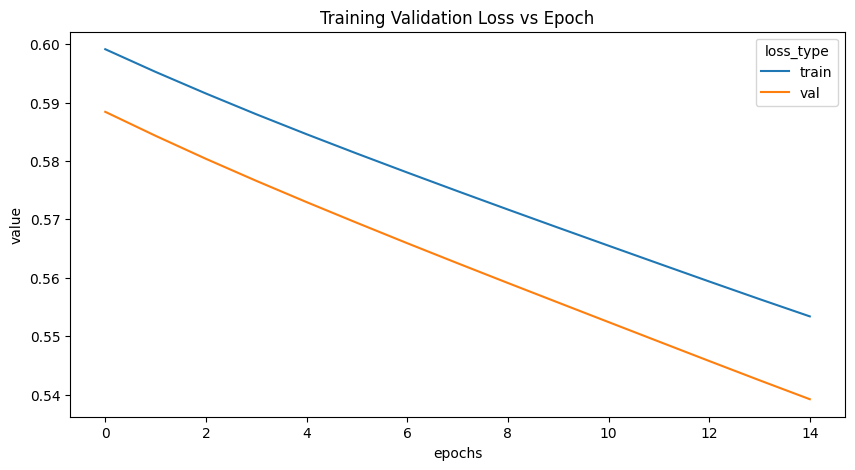

In [161]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

# create an instance of SimpleNeuralNet class
model = LogisticRegressionNN(num_features=26).to(device)

loss_fn = nn.SoftMarginLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-2)

losses = {
    "train": [],
    "val": []
}

no_of_epochs = 15
for epoch in range(no_of_epochs):
    print(f'Epoch  {epoch: .0f}')

    train_epoch_loss = 0
    val_epoch_loss = 0

    # set the model to training mode
    model.train()
    print(f'-----Training--------')
    for X_train_batch, y_train_batch in train_dl:
        optimizer.zero_grad()
        # Move data to the same device as the model
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)

        # Generate predictions and compute loss
        preds = model(X_train_batch)

        train_loss = loss_fn(preds, y_train_batch)
        print(f'Training Loss = {train_loss:.3f}' )

        # Perform gradient descent
        train_loss.backward()

        optimizer.step()

        train_epoch_loss += train_loss.item()
    train_loss = train_epoch_loss / len(train_dl)
    losses["train"].append(train_loss)

    # VALIDATION
    print(f'-----Validation--------')
    with torch.no_grad():
        model.eval()
        for X_val_batch, y_val_batch in val_dl:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch)
            val_loss = loss_fn(y_val_pred, y_val_batch)
            accuracy = binary_accuracy(y_val_pred,y_val_batch)
            print(f'Val Loss={val_loss:.3f} | Accuracy={accuracy:.3f}')  
            val_epoch_loss += val_loss.item()
        val_loss = val_epoch_loss / len(val_dl)    
        losses["val"].append(val_loss)

    print(f'Epoch {epoch:.0f} : Training Loss = {train_loss:.3f} |  Validation Loss= {val_loss:.3f}******' )

loss_df = pd.DataFrame.from_dict(losses).reset_index().melt(id_vars = ["index"], var_name="loss_type").rename(columns = {"index": "epochs"})
loss_df.head()
%matplotlib 

plt.figure(figsize = (10, 5))

sns.lineplot(data = loss_df,
             x = "epochs", y = "value",
             hue = "loss_type"
).set_title("Training Validation Loss vs Epoch")    

In [ ]:
y_true = []
y_pred = []

with torch.no_grad():

    model.eval()

    for X_batch, y_batch in test_dl:
        X_batch = X_batch.to(device)

        y_test_pred = model(X_batch)

        y_true.extend(y_batch)
        y_pred.extend(y_test_pred)

In [ ]:
y_true_stacked = torch.stack((y_true))

y_true_stacked[:10]